In [22]:
import numpy as np
import pandas as pd
import pymc3 as pm
#import pymc3.sampling_jax
import theano
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
print(f'Running on PyMC3 v{pm.__version__}')


Running on PyMC3 v3.10.0


In [14]:
train = pd.read_csv('/Users/gabestechschulte/Downloads/customer-churn-prediction-2020/train.csv')
train.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [15]:
# Preprocessing
train.churn = train.churn.apply(lambda x: 0 if x == 'no' else 1)

feats = train[['account_length', 'total_day_minutes', 
               'total_day_charge', 'number_customer_service_calls']]


scaler = StandardScaler()
trainScale = scaler.fit_transform(feats)

data = {'account_length': trainScale[:, 0],
        'total_day_minutes': trainScale[:, 1],
        'total_day_charge': trainScale[:, 2],
        'number_customer_service_calls': trainScale[:, 3]}

trainScale = pd.DataFrame(data)
trainScale.head()
trainScale['churn'] = train['churn']
trainScale.head()


,account_length,total_day_minutes,total_day_charge,number_customer_service_calls,churn
0,0.170399,-0.345510,-0.345788,-0.426346,0
1,0.926186,1.169136,1.169295,-1.188960,0
2,-0.409038,2.206058,2.206218,0.336268,0
3,-0.635774,-0.251076,-0.251027,1.098882,0
4,0.523099,0.702522,0.702027,1.098882,0


<AxesSubplot:xlabel='churn', ylabel='count'>

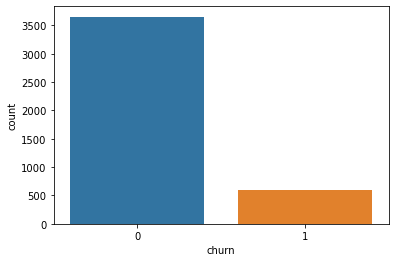

In [27]:
# Class Imbalance
sns.countplot(x=trainScale.churn)

## The Model

The apply rate is defined as the fraction of applies (after visiting job description pages), and the goal is to predict this metric using the dataset described in the following section.

Assuming the probability of applying is a function of the features, we will use PyMC3 to perform inference

Specification of prior and likelihoods in order to draw samples from the posterior
 - Prior
 - Likelihood

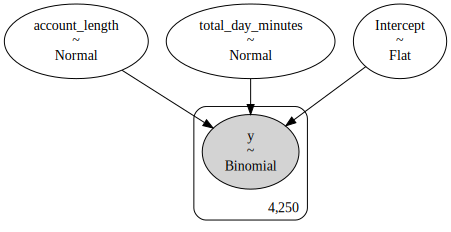

In [28]:
simple_model = 'churn ~ account_length + total_day_minutes'
full_model = 'churn ~ account_length + total_day_minutes + total_day_charge + number_customer_service_calls'

with pm.Model() as logistic_regression:
    pm.glm.GLM.from_formula(formula=simple_model,
                            data=trainScale,
                            family=pm.glm.families.Binomial())

#logistic_regression.basic_RVs
pm.model_to_graphviz(logistic_regression)

In [32]:
with logistic_regression:
    trace = pm.sample(tune=1000,
                      draws=1000,
                      chains=2,
                      init='adapt_diag',
                      cores=2)

/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [total_day_minutes, account_length, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.


/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'account_length'}>,
        <AxesSubplot:title={'center':'account_length'}>],
       [<AxesSubplot:title={'center':'total_day_minutes'}>,
        <AxesSubplot:title={'center':'total_day_minutes'}>]], dtype=object)

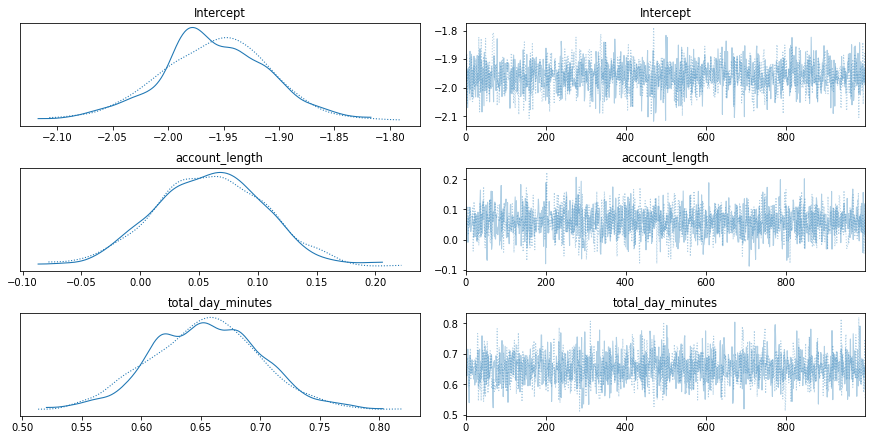

In [33]:
pm.traceplot(trace)

In [35]:
pm.summary(trace)

/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.959,0.050,-2.056,-1.864,0.001,0.001,1772.0,1772.0,1766.0,1127.0,1.0
account_length,0.059,0.046,-0.025,0.148,0.001,0.001,1998.0,1664.0,1999.0,1398.0,1.0
total_day_minutes,0.655,0.047,0.567,0.748,0.001,0.001,2009.0,1990.0,2016.0,1532.0,1.0


/Users/gabestechschulte/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


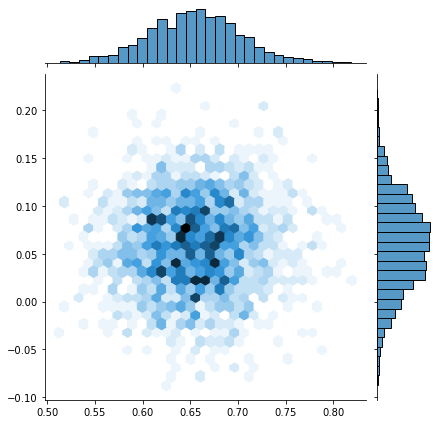

In [37]:
# How does "total day minutes" and "account length" affect the probability of a customer churning?
sns.jointplot(trace['total_day_minutes'], trace['account_length'], kind='hex')
plt.xlabel('Total Day Minutes')
plt.ylabel('Account Length')
plt.show()

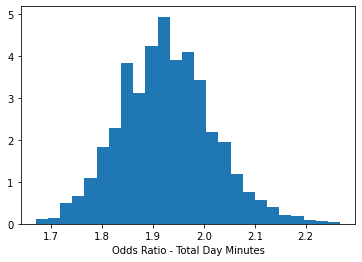

In [46]:
# Odds Ratio
plt.hist(np.exp(trace['total_day_minutes']), bins=25, density=True)
plt.xlabel('Odds Ratio - Total Day Minutes')
plt.show()


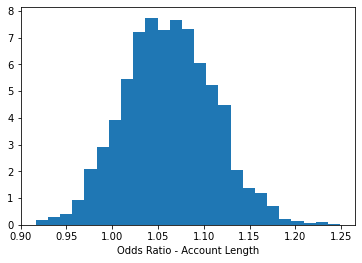

In [47]:
# Odds Ratio
plt.hist(np.exp(trace['account_length']), bins=25, density=True)
plt.xlabel('Odds Ratio - Account Length')
plt.show()